# <Font color = 'indianred'>**1. Set Environment**

<font color = 'indianred'> **1.1 Mount Google Drive** </font>

In [1]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  !pip install torchinfo -qq

  basepath = '/content/drive/MyDrive/data/'


Mounted at /content/drive


In [3]:
# Data prepararation
from sklearn.model_selection import train_test_split

# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np
import pandas as pd
import os

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
from datetime import datetime
from sklearn.utils.class_weight import compute_class_weight

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

# imports from Huggingface ecosystem
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import PreTrainedModel, PretrainedConfig
from transformers import TrainingArguments, Trainer
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, AutoModel
from transformers import AutoConfig
from transformers import DataCollatorWithPadding
from transformers import pipeline
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel


# wandb library
import wandb

In [4]:
# Define the device for model training (use CUDA if available, else CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## <Font color = 'indianred'>**2. Load Data** </font>

In [5]:
# Set the base folder path using the Path class for better path handling
base_folder = Path(basepath)

# Define the data folder path by appending the relative path to the base folder
# This is where the data files will be stored
data_folder = base_folder / 'dataset/hw6'

# Define the model folder path for saving trained models
# This path points to a specific folder designated for NLP models related to the IMDb dataset
model_folder = base_folder / 'models/hw6'

In [6]:
# Create the model folder directory. If it already exists, do nothing.
# The 'parents=True' argument ensures that all parent directories are created if they don't exist.
model_folder.mkdir(exist_ok=True, parents=True)

# Create the data folder directory in a similar manner.
data_folder.mkdir(exist_ok=True, parents=True)

In [7]:
# Set the file path
train_file_path = X_train_cleaned_file = data_folder / 'train.csv'
test_file_path = X_test_cleaned_file = data_folder / 'test.csv'

In [8]:
# Load the data
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

In [9]:
# Preview training data
train_df

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7719,2018-01993,@BadHombreNPS @SecretaryPerry If this didn't m...,1,0,1,0,0,0,0,0,0,0,0
7720,2018-01784,Excited to watch #stateoforigin tonight! Come ...,0,0,0,0,1,0,1,0,0,0,0
7721,2018-04047,"Blah blah blah Kyrie, IT, etc. @CJC9BOSS leavi...",1,0,1,0,0,0,0,0,1,0,0
7722,2018-03041,#ThingsIveLearned The wise #shepherd never tru...,0,0,0,0,0,0,0,0,0,0,0


In [10]:
# look at the distribution of different classes
train_df.sum()

,0
ID,2017-214412017-315352017-210682017-314362017-2...
Tweet,“Worry is a down payment on a problem you may ...
anger,2859
anticipation,1102
disgust,2921
fear,1363
joy,2877
love,832
optimism,2291
pessimism,895


In [11]:
# tranforming train data
X = train_df.iloc[:,1].to_numpy()
y = train_df.iloc[:, 2:].values.tolist()

# transforming test data
X_test = test_df.iloc[:,1].to_numpy()
y_test = test_df.iloc[:, 2:].values.tolist()

In [12]:
# target columns after transformation
y[:5]

[[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]

## <Font color = 'indianred'>**3. Training/Validation Split**

In [13]:
# create huggingface dataset
trainset = Dataset.from_dict({
    'text': X,
    'label': y
})

testset = Dataset.from_dict({
    'text': X_test,
    'label': y_test
})

In [14]:
# Split the test set into test and validation sets
train_val_splits = trainset.train_test_split(test_size=0.5, seed=42,)
train_split = train_val_splits['train']
val_split = train_val_splits['test']

In [15]:
# small subset for initial experimentation
train_split = train_split.shuffle(seed = 42).select(range(1500))
val_split = val_split.shuffle(seed = 42).select(range(1500))

In [16]:
train_val_subset= DatasetDict(
    {"train": train_split, "valid": val_split})

In [17]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1500
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1500
    })
})

In [18]:
train_val_subset['train']['label'][0]

[0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]

In [19]:
train_val_subset['train']['text'][0]

'Even death is unreliable. Instead of zero it may be some ghastly hallucination, such as the square root of minus one.  Samuel Beckett'

## <Font color = 'indianred'>**4. Model Training - RoBERTa Base Model** </font>

In [20]:
# load model tokenizer
checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


<font color = 'indianred'> **4.1 Tokenize Labels** </font>

In [21]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

In [22]:
tokenized_dataset= train_val_subset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [23]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1500
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1500
    })
})

In [24]:
tokenized_dataset['train']['attention_mask'][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1])

In [25]:
tokenized_dataset = (tokenized_dataset
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [26]:
tokenized_dataset['train']['label'][0:3]

tensor([[0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.]])

<font color = 'indianred'> **4.2 Model Training** </font>

In [27]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 11, problem_type="multi_label_classification")
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [28]:
class_names = ["anger","anticipation","disgust","fear","joy","love","optimism","pessimism","sadness","surprise","trust"]

In [29]:
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
config.id2label = id2label
config.label2id = label2id
model.config = config

In [30]:
# load training metrices
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, label = eval_pred
    preds = (logits > 0).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=label.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=label)
    f1_micro = f1.compute(predictions=preds, references=label, average='micro')
    f1_macro = f1.compute(predictions=preds, references=label, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [31]:
# Define the directory where model checkpoints will be saved
model_folder = Path(model_folder / 'roberta-base')
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'tweet_exp1_roberta-base'

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases
)


In [32]:
# Assuming labels is a 2D array with shape (num_samples, num_classes)
labels = train_split['label']

y_train = np.array(labels)

# Calculate the positive count for each class
class_counts = y_train.sum(axis=0)

# Calculate the weights for each class
num_samples = y_train.shape[0]
class_weights = num_samples / (class_counts + 1e-6)  # Small epsilon to avoid division by zero
class_weights = torch.tensor(class_weights, dtype=torch.float)

print("Class weights:", class_weights)

Class weights: tensor([ 2.6224,  7.4257,  2.6834,  5.9055,  2.6596,  9.8039,  3.3632,  8.5227,
         3.5545, 17.8571, 18.9873])


In [33]:
# Custom loss function with class weights
class WeightedBCELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedBCELoss, self).__init__()
        self.weights = weights

    def forward(self, logits, targets):
        # BCEWithLogitsLoss expects logits as inputs
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=self.weights)
        return loss_fn(logits, targets)

In [34]:
class CustomTrainer(Trainer):
    def __init__(self, *args, weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = WeightedBCELoss(weights=weights.to(model.device))

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [35]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    weights=class_weights
)

In [36]:
from google.colab import userdata

secret_key = userdata.get("wandb_key")

wandb.login(key=secret_key)
%env WANDB_PROJECT = multilabel_tweet

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=multilabel_tweet


In [37]:
trainer.train()

wandb: Currently logged in as: psatyarv (psatyarv-the-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy Label,Accuracy All
20,1.206700,1.245371,0.397447,0.307765,0.404970,0.000000
40,1.238100,1.241715,0.381789,0.326788,0.334242,0.000000
60,1.232200,1.223822,0.414215,0.341031,0.448545,0.000000
80,1.217500,1.165182,0.424603,0.381031,0.443818,0.000000
100,1.112100,1.067070,0.485127,0.439011,0.606606,0.002667
120,1.021200,1.018549,0.518607,0.467640,0.659758,0.002667
140,0.997100,0.988900,0.512821,0.470291,0.645333,0.002667
160,0.997400,0.977427,0.512691,0.469578,0.648606,0.002667
180,1.021400,0.968999,0.520697,0.474045,0.658242,0.002667


TrainOutput(global_step=188, training_loss=1.1110525334135015, metrics={'train_runtime': 184.475, 'train_samples_per_second': 16.262, 'train_steps_per_second': 1.019, 'total_flos': 70151486769000.0, 'train_loss': 1.1110525334135015, 'epoch': 2.0})

<font color = 'indianred'> **4.3 Evaluate model on Validation Set** </font>

In [38]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [39]:
eval_results

{'eval_loss': 0.9689986705780029,
 'eval_f1_micro': 0.5206969825754356,
 'eval_f1_macro': 0.4740454203341422,
 'eval_accuracy_label': 0.6582424242424243,
 'eval_accuracy_all': 0.0026666666666666666,
 'eval_runtime': 4.3673,
 'eval_samples_per_second': 343.458,
 'eval_steps_per_second': 21.523,
 'epoch': 2.0}

In [40]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"], "eval_loss": eval_results["eval_loss"], "eval_accuracy": eval_results["eval_accuracy_all"]})

<font color = 'indianred'> **4.4 Confusion Matrix** </font>

In [41]:
valid_output = trainer.predict(tokenized_dataset["valid"])

In [42]:
valid_preds = np.array((valid_output.predictions > 0).astype(int))
valid_labels = np.array(valid_output.label_ids.astype(int))

In [43]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


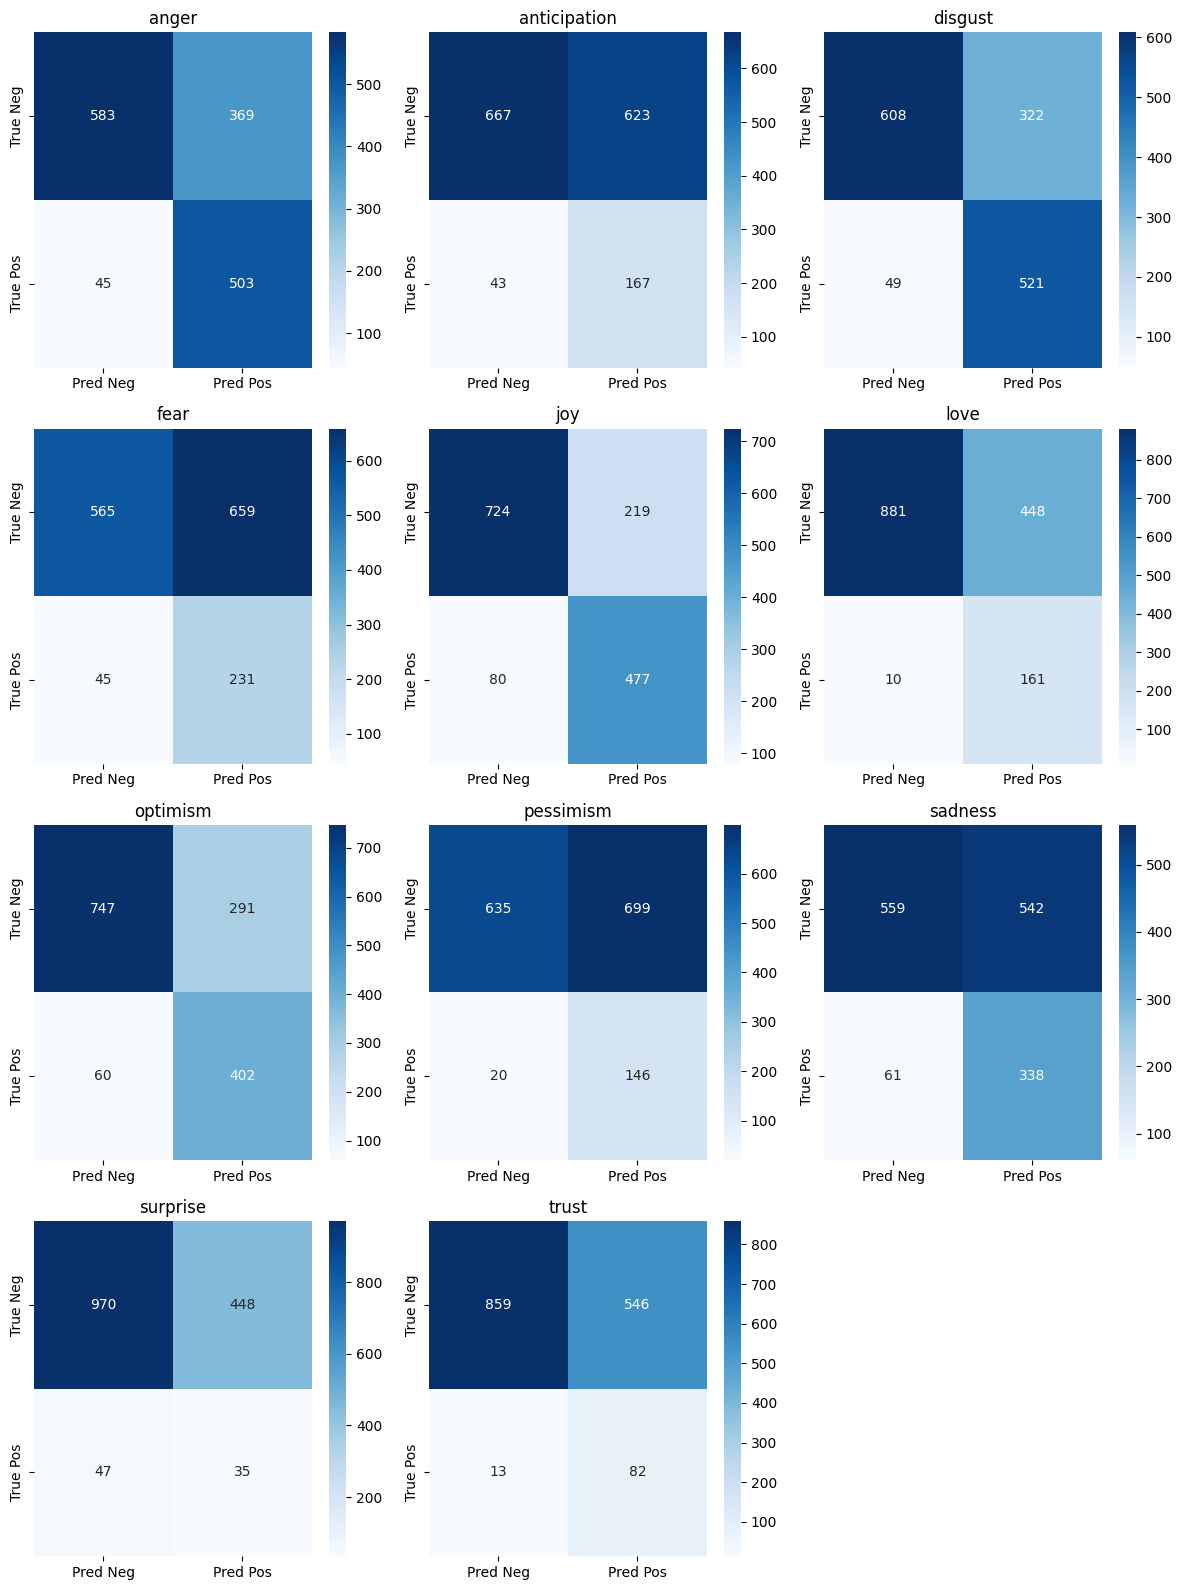

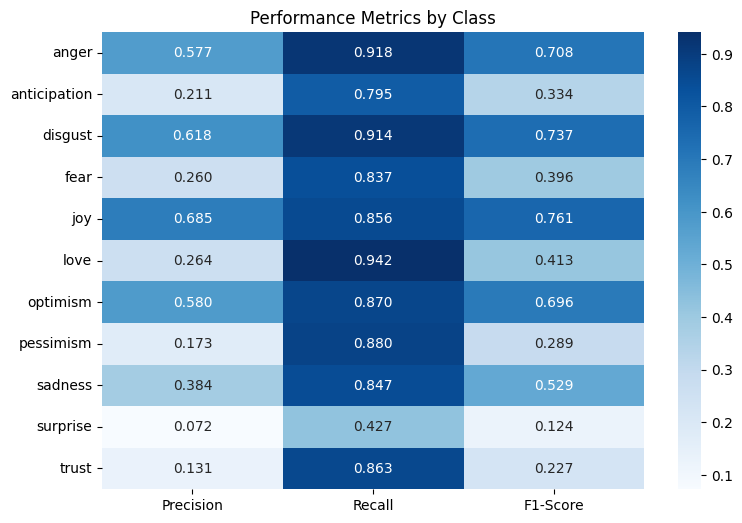

<Figure size 1200x533.333 with 0 Axes>

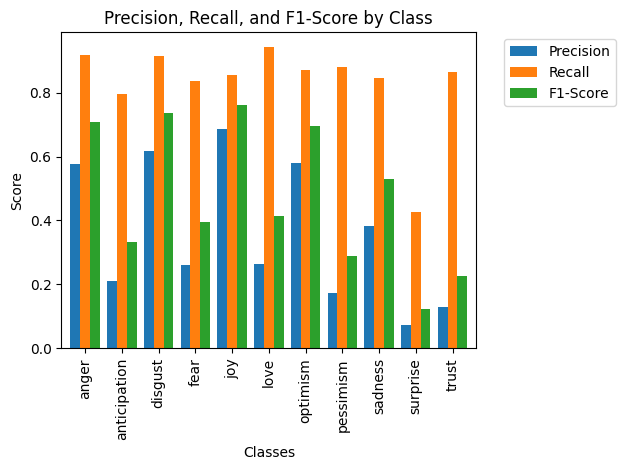

{'macro_avg': {'precision': 0.35959244417677166,
  'recall': 0.8317054284755238,
  'f1': 0.4740454203341422},
 'per_class': {'Precision': {'anger': 0.5768348623853211,
   'anticipation': 0.21139240506329113,
   'disgust': 0.6180308422301305,
   'fear': 0.2595505617977528,
   'joy': 0.6853448275862069,
   'love': 0.26436781609195403,
   'optimism': 0.5800865800865801,
   'pessimism': 0.1727810650887574,
   'sadness': 0.3840909090909091,
   'surprise': 0.07246376811594203,
   'trust': 0.1305732484076433},
  'Recall': {'anger': 0.9178832116788321,
   'anticipation': 0.7952380952380952,
   'disgust': 0.9140350877192982,
   'fear': 0.8369565217391305,
   'joy': 0.8563734290843806,
   'love': 0.9415204678362573,
   'optimism': 0.8701298701298701,
   'pessimism': 0.8795180722891566,
   'sadness': 0.8471177944862155,
   'surprise': 0.4268292682926829,
   'trust': 0.8631578947368421},
  'F1-Score': {'anger': 0.7084507042253522,
   'anticipation': 0.334,
   'disgust': 0.7374380750176929,
   'fea

In [44]:
multilabel_evaluation(y_true=valid_labels, y_pred=valid_preds, class_names=class_names, figsize=(12, 8))

<font color = 'indianred'> **4.5 Get best checkpoint**</font>


In [45]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 180.


In [46]:
wandb.finish()

eval/accuracy_all,▁▁▁▁██████
eval/accuracy_label,▃▁▃▃▇█████
eval/f1_macro,▁▂▂▄▇█████
eval/f1_micro,▂▁▃▃▆█████
eval/loss,██▇▆▃▂▂▁▁▁
eval/runtime,█▃▄▁▁▃▂▂▂▁
eval/samples_per_second,▁▅▄██▅▇▆▆▇
eval/steps_per_second,▁▅▄██▅▇▆▆▇
eval_accuracy,▁
eval_f1_macro,▁
eval_loss,▁
